In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
x1, x2 = np.meshgrid(np.linspace(-50., 50., num=101), np.linspace(-50., 50., num=101))

In [3]:
x1, x2 = np.reshape(x1, (101**2,)), np.reshape(x2, (101**2,))
x1.shape, x2.shape

((10201,), (10201,))

In [4]:
Y = (x1+x2)%2
Y.shape

(10201,)

In [5]:
X = torch.cat([torch.tensor(x1, dtype=torch.float32).unsqueeze(1), torch.tensor(x2, dtype=torch.float32).unsqueeze(1)], axis=1)
X.shape

torch.Size([10201, 2])

In [6]:
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
Y.shape

torch.Size([10201, 1])

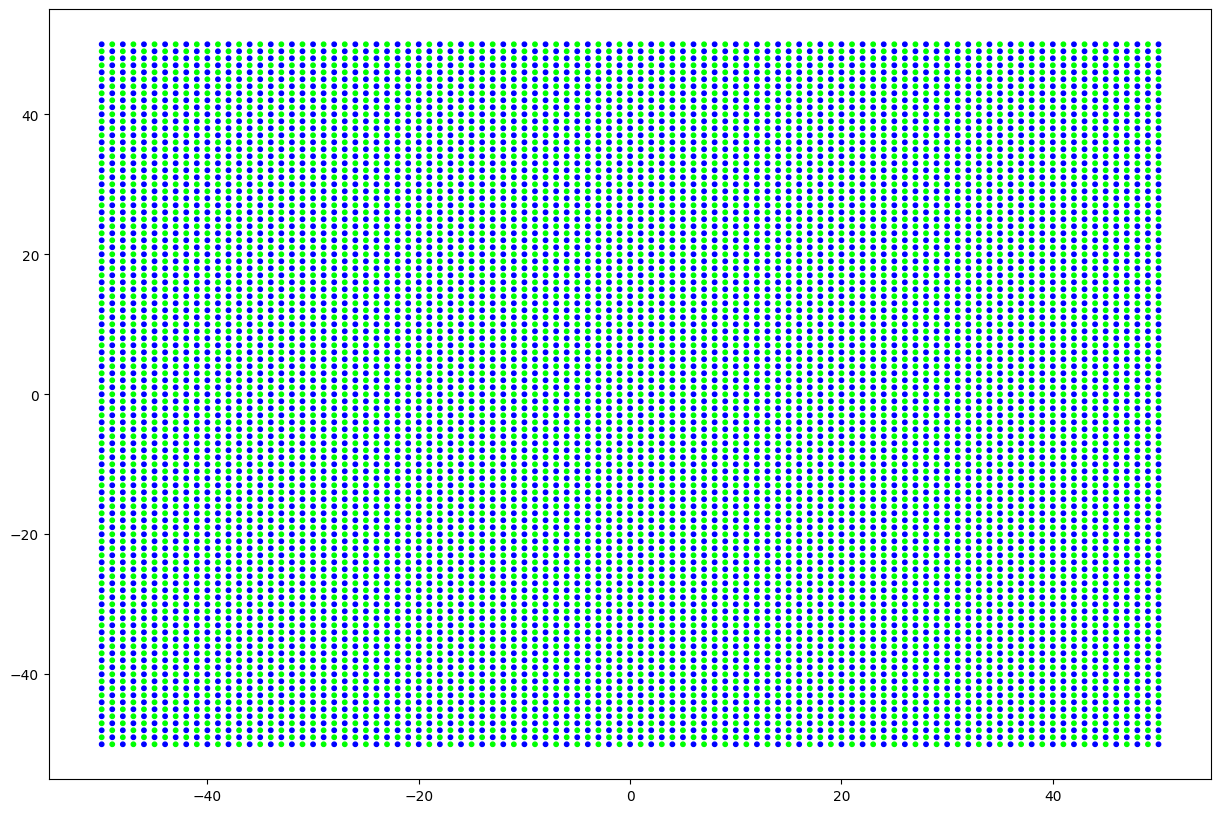

In [7]:
plt.figure(figsize=(15, 10))
plt.scatter(X[:,0], X[:,1], c=Y, s=10, cmap='brg')

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([8160, 2]),
 torch.Size([2041, 2]),
 torch.Size([8160, 1]),
 torch.Size([2041, 1]))

### SVM

In [10]:
from sklearn.svm import SVC

In [11]:
model = SVC()
# Try kernel like cos((x1+x2)/4)??

In [12]:
model.fit(X_train, Y_train.squeeze())

SVC()

In [13]:
preds_train, preds_val = model.predict(X_train), model.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(0.509313725490196, 0.4644781969622734)

### ANN

In [10]:
device = 'cpu'

In [11]:
from torch import nn
from scripts.activations import ExpNegSq, ExpNegMod, DiscExpNegMod, Mod, Sq

activation = DiscExpNegMod()

class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=32),
            # nn.ReLU(),
            # DiscExpNegMod(),
            activation,
            nn.Linear(in_features=32, out_features=32),
            # activation,
            nn.Linear(in_features=32, out_features=32),
            # activation,
            nn.Linear(in_features=32, out_features=32),
            # activation,
            nn.Linear(in_features=32, out_features=32),
            # activation,
            nn.Linear(in_features=32, out_features=32),
            # activation,
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

In [12]:
model = SimpleNN().to(device)

In [13]:
from scripts.metrics import BinaryAccuracy

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
metric = BinaryAccuracy()

In [14]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 32, True), make_dataloader(X_val, Y_val, 32)

In [15]:
from scripts.train import train_classifier

history = train_classifier(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    metric=metric,
    optimizer=optimizer,
    epochs=50,
    device=device
)

Training model for 50 epochs. Early stopping not enabled.
Epoch: 1 => Train loss: 0.693751, Train score: 0.497917, Val loss: 0.693623, Val score: 0.491172
Epoch: 2 => Train loss: 0.693405, Train score: 0.506250, Val loss: 0.692877, Val score: 0.508828
Epoch: 3 => Train loss: 0.693590, Train score: 0.493750, Val loss: 0.693030, Val score: 0.508828
Epoch: 4 => Train loss: 0.693266, Train score: 0.500123, Val loss: 0.693940, Val score: 0.491172
Epoch: 5 => Train loss: 0.693344, Train score: 0.503431, Val loss: 0.693161, Val score: 0.506387
Epoch: 6 => Train loss: 0.693117, Train score: 0.507843, Val loss: 0.693348, Val score: 0.508828
Epoch: 7 => Train loss: 0.693474, Train score: 0.494608, Val loss: 0.693364, Val score: 0.476523
Epoch: 8 => Train loss: 0.693314, Train score: 0.498039, Val loss: 0.693131, Val score: 0.508340
Epoch: 9 => Train loss: 0.693295, Train score: 0.496569, Val loss: 0.693566, Val score: 0.491172
Epoch: 10 => Train loss: 0.693346, Train score: 0.494363, Val loss: 0

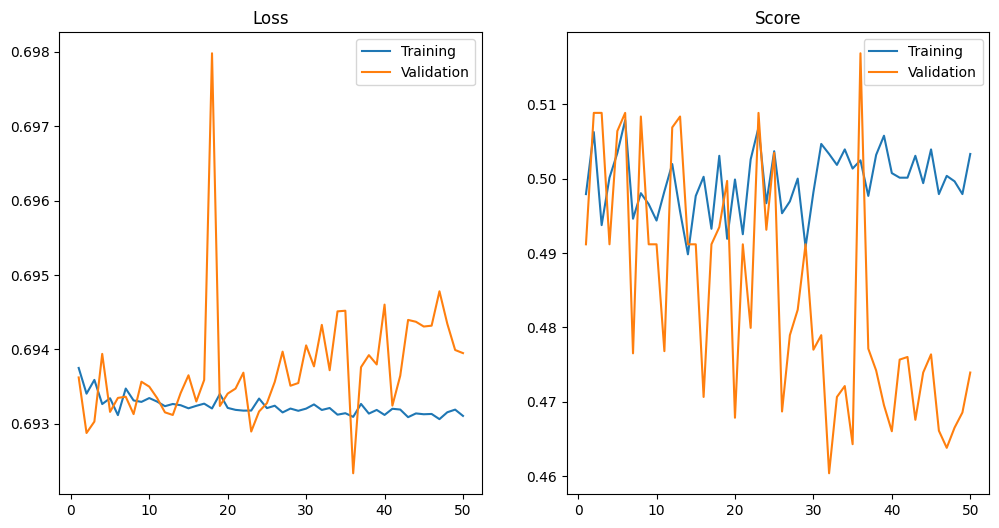

In [16]:
from scripts.utils import plot_train_history

plot_train_history(history)